In [1]:
import pandas as pd

# Load Supplementary Data
supplementary_df = pd.read_csv('supplementary_data.csv')

# Load all 18 weeks of Input/Output data
input_dfs = []
output_dfs = []

print("Starting data load...")

# Loop through weeks 1 to 18
for week in range(1, 19):
    # Format week number with leading zero (e.g., 1 -> '01', 10 -> '10')
    week_str = f"{week:02d}"
    
    # Construct file names
    input_file = f"input_2023_w{week_str}.csv"
    output_file = f"output_2023_w{week_str}.csv"
    
    try:
        # Read files
        curr_input = pd.read_csv(input_file)
        curr_output = pd.read_csv(output_file)
        
        # Append to lists
        input_dfs.append(curr_input)
        output_dfs.append(curr_output)
        print(f"Week {week_str} loaded.")
        
    except FileNotFoundError:
        print(f"Warning: Files for Week {week_str} not found. Skipping.")

# Concatenate all weeks into single DataFrames
if input_dfs and output_dfs:
    input_df = pd.concat(input_dfs, ignore_index=True)
    output_df = pd.concat(output_dfs, ignore_index=True)

    print("-" * 30)
    print("Final Load Complete:")
    print(f"Supplementary Data: {supplementary_df.shape}")
    print(f"All Input Data: {input_df.shape}")
    print(f"All Output Data: {output_df.shape}")
else:
    print("No data was loaded. Please check your file paths.")

/var/folders/52/8k91wm1s4w33nj2kfkvh5rbc0000gn/T/ipykernel_34290/2458996510.py:4: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supplementary_df = pd.read_csv('supplementary_data.csv')


Starting data load...
Week 01 loaded.
Week 02 loaded.
Week 03 loaded.
Week 04 loaded.
Week 05 loaded.
Week 06 loaded.
Week 07 loaded.
Week 08 loaded.
Week 09 loaded.
Week 10 loaded.
Week 11 loaded.
Week 12 loaded.
Week 13 loaded.
Week 14 loaded.
Week 15 loaded.
Week 16 loaded.
Week 17 loaded.
Week 18 loaded.
------------------------------
Final Load Complete:
Supplementary Data: (18009, 41)
All Input Data: (4880579, 23)
All Output Data: (562936, 6)


In [2]:
import numpy as np

# Standardize Play Direction and Ball Landing Coordinates

# Build a per-play lookup for direction and ball landing location
play_metadata = input_df[['game_id', 'play_id', 'play_direction', 'ball_land_x', 'ball_land_y']].drop_duplicates(subset=['game_id', 'play_id'])

# Attach play-level info to output_df
output_df = output_df.merge(play_metadata, on=['game_id', 'play_id'], how='left')


# Flip coordinates so all plays go left-to-right
def standardize_coordinates(df):
    # Create a mask for plays moving left
    left_mask = df['play_direction'] == 'left'
    
    # Flip player coordinates
    df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
    df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
    
    # Flip ball landing coordinates
    if 'ball_land_x' in df.columns:
        df.loc[left_mask, 'ball_land_x'] = 120 - df.loc[left_mask, 'ball_land_x']
        df.loc[left_mask, 'ball_land_y'] = 53.3 - df.loc[left_mask, 'ball_land_y']
        
    return df

print("Standardizing Input Data")
input_df = standardize_coordinates(input_df)

print("Standardizing Output Data")
output_df = standardize_coordinates(output_df)


# Check our reesults
print("\nStandardization Complete.")
print(f"Input columns: {input_df.columns.tolist()}")
print(f"Output columns: {output_df.columns.tolist()}")
print("Ready for Coordinate Rotation (Step 3).")

Standardizing Input Data
Standardizing Output Data

Standardization Complete.
Input columns: ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y']
Output columns: ['game_id', 'play_id', 'nfl_id', 'frame_id', 'x', 'y', 'play_direction', 'ball_land_x', 'ball_land_y']
Ready for Coordinate Rotation (Step 3).


In [3]:
# Rotate coordinates so every play is centered at the ball landing spot, and "toward the QB" is always the +Y direction

print("Identifying QB positions")

# Identify QB position from last frame of input data
# Filter for the passer in the input dataframe
passer_df = input_df[input_df['player_role'] == 'Passer'].copy()

# Get the last frame for each passer on each play (the moment before/at the throw)
passer_last_frame = passer_df.sort_values(['game_id', 'play_id', 'frame_id']).groupby(['game_id', 'play_id']).tail(1)

# Keep only the columns we need and rename them
qb_locs = passer_last_frame[['game_id', 'play_id', 'x', 'y']].rename(columns={'x': 'qb_x', 'y': 'qb_y'})

# Merge QB location onto the output_df
output_df = output_df.merge(qb_locs, on=['game_id', 'play_id'], how='left')

# Drop plays where we couldn't find a QB
initial_len = len(output_df)
output_df = output_df.dropna(subset=['qb_x', 'qb_y'])
print(f"Dropped {initial_len - len(output_df)} rows where QB tracking data was missing.")

# Perform Rotation of Coordinate System
print("Rotating coordinate system")

# Translate everything so Ball Landing is at (0,0)
output_df['x_relative'] = output_df['x'] - output_df['ball_land_x']
output_df['y_relative'] = output_df['y'] - output_df['ball_land_y']

# Calculate vector from Ball to QB
output_df['qb_dx'] = output_df['qb_x'] - output_df['ball_land_x']
output_df['qb_dy'] = output_df['qb_y'] - output_df['ball_land_y']

# Calculate the angle of the Ball to QB vector relative to the field
output_df['angle_to_qb'] = np.arctan2(output_df['qb_dy'], output_df['qb_dx'])

# Calculate the required rotation angle
# We want the QB vector to align with Pi/2 (90 degrees, Positive Y)
output_df['rotation_angle'] = (np.pi / 2) - output_df['angle_to_qb']

# Apply Rotation Matrix, with our new X and Y values calculated below
output_df['x_rotated'] = (output_df['x_relative'] * np.cos(output_df['rotation_angle']) - 
                          output_df['y_relative'] * np.sin(output_df['rotation_angle']))

output_df['y_rotated'] = (output_df['x_relative'] * np.sin(output_df['rotation_angle']) + 
                          output_df['y_relative'] * np.cos(output_df['rotation_angle']))

print("Rotation Complete.")
print("New columns 'x_rotated' and 'y_rotated' created.")
print("Positive Y = Underneath (Towards QB)")
print("Negative Y = Overtop (Away from QB)")

Identifying QB positions
Dropped 137 rows where QB tracking data was missing.
Rotating coordinate system
Rotation Complete.
New columns 'x_rotated' and 'y_rotated' created.
Positive Y = Underneath (Towards QB)
Negative Y = Overtop (Away from QB)


In [4]:
# Quick sanity checks on the rotated coordinates

# Rotate the QB vector too — QB should end up basically on x = 0 for every play
output_df['qb_x_rotated'] = (output_df['qb_dx'] * np.cos(output_df['rotation_angle']) - 
                             output_df['qb_dy'] * np.sin(output_df['rotation_angle']))

output_df['qb_y_rotated'] = (output_df['qb_dx'] * np.sin(output_df['rotation_angle']) + 
                             output_df['qb_dy'] * np.cos(output_df['rotation_angle']))

print("--- Check 1: QB Position Verification ---")
print("The QB's X-coordinate should be effectively 0.")
print("The QB's Y-coordinate should be positive (distance from throw).")
print(output_df[['qb_x_rotated', 'qb_y_rotated']].describe().round(4))

# Check the distribution of player positions
print("\n--- Check 2: Player Position Distribution ---")
print("Look for extreme outliers (e.g., +/- 100 yards) which indicate errors.")
print(output_df[['x_rotated', 'y_rotated']].describe().round(2))


# Check a random play to see if the values make sense intuitively
sample_play = output_df.iloc[0]
print("\n--- Check 3: Single Row Spot Check ---")
print(f"Play ID: {sample_play['play_id']}")
print(f"Ball Land: (0, 0)")
print(f"QB Location: ({sample_play['qb_x_rotated']:.2f}, {sample_play['qb_y_rotated']:.2f})")
print(f"Player Location: ({sample_play['x_rotated']:.2f}, {sample_play['y_rotated']:.2f})")

--- Check 1: QB Position Verification ---
The QB's X-coordinate should be effectively 0.
The QB's Y-coordinate should be positive (distance from throw).
       qb_x_rotated  qb_y_rotated
count      562799.0   562799.0000
mean            0.0       27.6128
std             0.0       11.9038
min            -0.0        0.7101
25%            -0.0       18.1633
50%             0.0       25.3934
75%             0.0       35.2800
max             0.0       67.2761

--- Check 2: Player Position Distribution ---
Look for extreme outliers (e.g., +/- 100 yards) which indicate errors.
       x_rotated  y_rotated
count  562799.00  562799.00
mean       -0.01       4.36
std         6.32       7.97
min       -33.09     -29.20
25%        -3.87      -0.92
50%         0.01       2.57
75%         3.85       8.68
max        34.99      48.12

--- Check 3: Single Row Spot Check ---
Play ID: 101
Ball Land: (0, 0)
QB Location: (0.00, 41.09)
Player Location: (6.69, 17.64)


In [5]:
# Calculate Total Number of Plays

# Count unique plays in our main dataframes
n_plays_supp = supplementary_df[['game_id', 'play_id']].drop_duplicates().shape[0]
n_plays_input = input_df[['game_id', 'play_id']].drop_duplicates().shape[0]
n_plays_output = output_df[['game_id', 'play_id']].drop_duplicates().shape[0]

print("Baseline Play Counts")
print(f"Total plays in Supplementary Data (Context): {n_plays_supp}")
print(f"Total plays in Input Data (Pre-Pass): {n_plays_input}")
print(f"Total plays in Output Data (Post-Pass, Rotated): {n_plays_output}")

# Calculate how many plays we lost during Coordinate Rotation and QB merge steps
dropped_plays = n_plays_input - n_plays_output
print(f"\nPlays dropped during processing (No QB/Bad Data): {dropped_plays}")
print(f"Percent of data remaining: {round((n_plays_output / n_plays_input) * 100, 2)}%")

Baseline Play Counts
Total plays in Supplementary Data (Context): 18009
Total plays in Input Data (Pre-Pass): 14108
Total plays in Output Data (Post-Pass, Rotated): 14105

Plays dropped during processing (No QB/Bad Data): 3
Percent of data remaining: 99.98%


In [6]:
# Filter Uncatchable Balls & Calculate WR Flow


print("Filtering Uncatchable Balls & Adding Flow Direction")

# Identify the Targeted Receiver for each play
receiver_map = input_df[input_df['player_role'] == 'Targeted Receiver'][['game_id', 'play_id', 'nfl_id']].drop_duplicates()

# Get the tracking data for these receivers from the output data
receiver_tracking = output_df.merge(receiver_map, on=['game_id', 'play_id', 'nfl_id'], how='inner')

# Calculate WR Flow Direction
print("Calculating Receiver Flow Direction...")

def get_flow_factor(group):
    # Ensure sorted by frame so we get accurate timeline
    group = group.sort_values('frame_id')
    
    # We want to compare the Moment of Catch vs. ~0.5 seconds ago (5 frames)
    if len(group) < 5:
        # Fallback for short tracking data: Use first available frame
        start_x = group.iloc[0]['x_rotated']
        end_x = group.iloc[-1]['x_rotated']
    else:
        start_x = group.iloc[-5]['x_rotated']
        end_x = group.iloc[-1]['x_rotated']
        
    velocity = end_x - start_x
    
    # Normalize X-Axis so Positive = "Behind" and Negative = "In Front"
    # If Velocity > 0 (Moving Left->Right): Came from Negative. We flip (-1) so "Coming From" becomes Positive.
    # If Velocity < 0 (Moving Right->Left): Came from Positive. We keep (1) so "Coming From" stays Positive.
    if velocity > 0:
        return -1 # Flip
    else:
        return 1  # Keep

# Apply this logic to every play
flow_factors = receiver_tracking.groupby(['game_id', 'play_id']).apply(get_flow_factor)
flow_df = flow_factors.reset_index(name='flow_factor')

# Merge 'flow_factor' back into the main Output DataFrame
output_df = output_df.merge(flow_df, on=['game_id', 'play_id'], how='left')

# Create the new Standardized Coordinate: 'x_flow'
# Positive X = Behind the Receiver (Trailing)
# Negative X = In Front of the Receiver (Cut-Off)
output_df['x_flow'] = output_df['x_rotated'] * output_df['flow_factor']

print("Flow Direction calculated. New column 'x_flow' added.")

# ------------------------------------------------

# Get the last frame for each receiver (Arrival Moment)
receiver_arrival = receiver_tracking.sort_values(['game_id', 'play_id', 'frame_id']).groupby(['game_id', 'play_id']).tail(1)

# Calculate Distance to Ball Landing Point
receiver_arrival['dist_to_ball'] = np.sqrt(
    receiver_arrival['x_relative']**2 + 
    receiver_arrival['y_relative']**2
)

# Identify Valid Plays (Distance <= 4 yards)
valid_plays = receiver_arrival[receiver_arrival['dist_to_ball'] <= 4.0]
valid_play_ids = set(zip(valid_plays['game_id'], valid_plays['play_id']))

# Apply Filter to Main DataFrames
pre_filter_count = output_df[['game_id', 'play_id']].drop_duplicates().shape[0]

# Filter Output Data
output_df = output_df[
    output_df.set_index(['game_id', 'play_id']).index.isin(valid_play_ids)
]

# Filter Input Data to match
input_df = input_df[
    input_df.set_index(['game_id', 'play_id']).index.isin(valid_play_ids)
]

post_filter_count = output_df[['game_id', 'play_id']].drop_duplicates().shape[0]
removed_count = pre_filter_count - post_filter_count

# Check if our filtering was successful
print(f"Plays before filter: {pre_filter_count}")
print(f"Plays removed (> 4 yards): {removed_count}")
print(f"Plays remaining: {post_filter_count}")

if pre_filter_count > 0:
    print(f"Percentage Removed: {round((removed_count / pre_filter_count) * 100, 2)}%")

# Check distribution of distances for removed plays (just to see what we cut)
removed_plays = receiver_arrival[receiver_arrival['dist_to_ball'] > 4.0]
if len(removed_plays) > 0:
    print("\nStats for Removed Plays (Receiver Distance to Ball):")
    print(removed_plays['dist_to_ball'].describe().round(2))

Filtering Uncatchable Balls & Adding Flow Direction
Calculating Receiver Flow Direction...
Flow Direction calculated. New column 'x_flow' added.
Plays before filter: 14105
Plays removed (> 4 yards): 818
Plays remaining: 13287
Percentage Removed: 5.8%

Stats for Removed Plays (Receiver Distance to Ball):
count    818.00
mean       6.41
std        3.19
min        4.00
25%        4.58
50%        5.46
75%        7.08
max       50.98
Name: dist_to_ball, dtype: float64


In [7]:
# Calculate Defender Distances

print("Calculating Defender Distances")

# Get player side data from input data
player_meta = input_df[['game_id', 'play_id', 'nfl_id', 'player_side']].drop_duplicates()

# This adds 'player_side' to our output dataframe
output_df = output_df.merge(player_meta, on=['game_id', 'play_id', 'nfl_id'], how='left')

# Filter for defensive players only
defenders_df = output_df[output_df['player_side'] == 'Defense'].copy()

# Get the last frame for each defender on each play
defender_arrival = defenders_df.sort_values(['game_id', 'play_id', 'frame_id']).groupby(['game_id', 'play_id', 'nfl_id']).tail(1)

# Calculate distance to ball landing point
defender_arrival['dist_to_ball'] = np.sqrt(
    defender_arrival['x_rotated']**2 + 
    defender_arrival['y_rotated']**2
)

# Inspect the results
print(f"Calculated distances for {len(defender_arrival)} defender instances.")
print("\n--- Defender Distance Stats (Yards from Ball) ---")
print(defender_arrival['dist_to_ball'].describe().round(2))

Calculating Defender Distances
Calculated distances for 29838 defender instances.

--- Defender Distance Stats (Yards from Ball) ---
count    29838.00
mean         7.19
std          5.15
min          0.01
25%          3.39
50%          6.10
75%          9.76
max         44.59
Name: dist_to_ball, dtype: float64


In [8]:
# Select Only the Closest Defender
print("Selecting Closest Defender per Play")

# Start fresh from the Output Data to ensure we get the right frames
# Filter for Defensive players only
defenders_all_frames = output_df[output_df['player_side'] == 'Defense'].copy()

# Select the last frame (Time of Catch) for each player
defender_arrival = defenders_all_frames.sort_values(['game_id', 'play_id', 'frame_id']).groupby(['game_id', 'play_id', 'nfl_id']).tail(1)

# Recalculate Distance (Just to be safe)
# Ensure we are using the coordinates from this specific 'arrival' frame
defender_arrival['dist_to_ball'] = np.sqrt(
    defender_arrival['x_rotated']**2 + 
    defender_arrival['y_rotated']**2
)

# Sort by Distance to Ball
closest_defenders_df = defender_arrival.sort_values(['game_id', 'play_id', 'dist_to_ball'])

# Keep only the single closest defender per play
closest_defenders_df = closest_defenders_df.drop_duplicates(subset=['game_id', 'play_id'], keep='first')

# Inspect results
print(f"Total plays with a tracked defender: {len(closest_defenders_df)}")
print("\n--- Closest Defender Distance Stats (Yards from Ball) ---")
print(closest_defenders_df['dist_to_ball'].describe().round(2))

# Check the result
print("\nColumns available for modeling:")
print(closest_defenders_df[['game_id', 'play_id', 'nfl_id', 'x_flow', 'y_rotated', 'dist_to_ball']].head())

Selecting Closest Defender per Play
Total plays with a tracked defender: 12182

--- Closest Defender Distance Stats (Yards from Ball) ---
count    12182.00
mean         3.54
std          2.30
min          0.01
25%          1.85
50%          3.11
75%          4.67
max         19.34
Name: dist_to_ball, dtype: float64

Columns available for modeling:
        game_id  play_id  nfl_id    x_flow  y_rotated  dist_to_ball
20   2023090700      101   46137  3.000610   3.830266      4.865655
98   2023090700      194   54653  0.895745  -0.170408      0.911811
115  2023090700      219   44888 -5.024081  -0.509311      5.049831
147  2023090700      361   46137  3.024187  -3.465139      4.599228
186  2023090700      436   46137  1.734740  -2.916365      3.393303


In [9]:
# Add Pass Results (Create Target Variable)

print("Adding Pass Outcomes")

# Get Pass Results from Supplementary Data
pass_outcomes = supplementary_df[['game_id', 'play_id', 'pass_result']].drop_duplicates()

# Merge onto our Closest Defender DataFrame
modeling_df = closest_defenders_df.merge(pass_outcomes, on=['game_id', 'play_id'], how='left')

# Create Binary Target Variable:
# 1 = Complete (C)
# 0 = Incomplete (I) or Interception (IN)
modeling_df['is_complete'] = (modeling_df['pass_result'] == 'C').astype(int)

# Inspect the Data
print(f"Total rows for modeling: {len(modeling_df)}")

print("\n--- Pass Result Distribution ---")
print(modeling_df['pass_result'].value_counts())

print("\n--- Target Variable Distribution (is_complete) ---")
print(modeling_df['is_complete'].value_counts(normalize=True).round(3))

# Check for missing values in pass_result (should be 0 if merge worked)
missing_results = modeling_df['pass_result'].isna().sum()
if missing_results > 0:
    print(f"\nWARNING: {missing_results} plays are missing a pass result.")

Adding Pass Outcomes
Total rows for modeling: 12182

--- Pass Result Distribution ---
pass_result
C     8562
I     3346
IN     274
Name: count, dtype: int64

--- Target Variable Distribution (is_complete) ---
is_complete
1    0.703
0    0.297
Name: proportion, dtype: float64


Calculating Bins
Binning complete.
Grid Dimensions: (18, 12)
Showing only boxes with >= 20 real plays.
Visualizing Raw Data
Placing (0,0) label at Grid Indices: X=6.0, Y=12.0


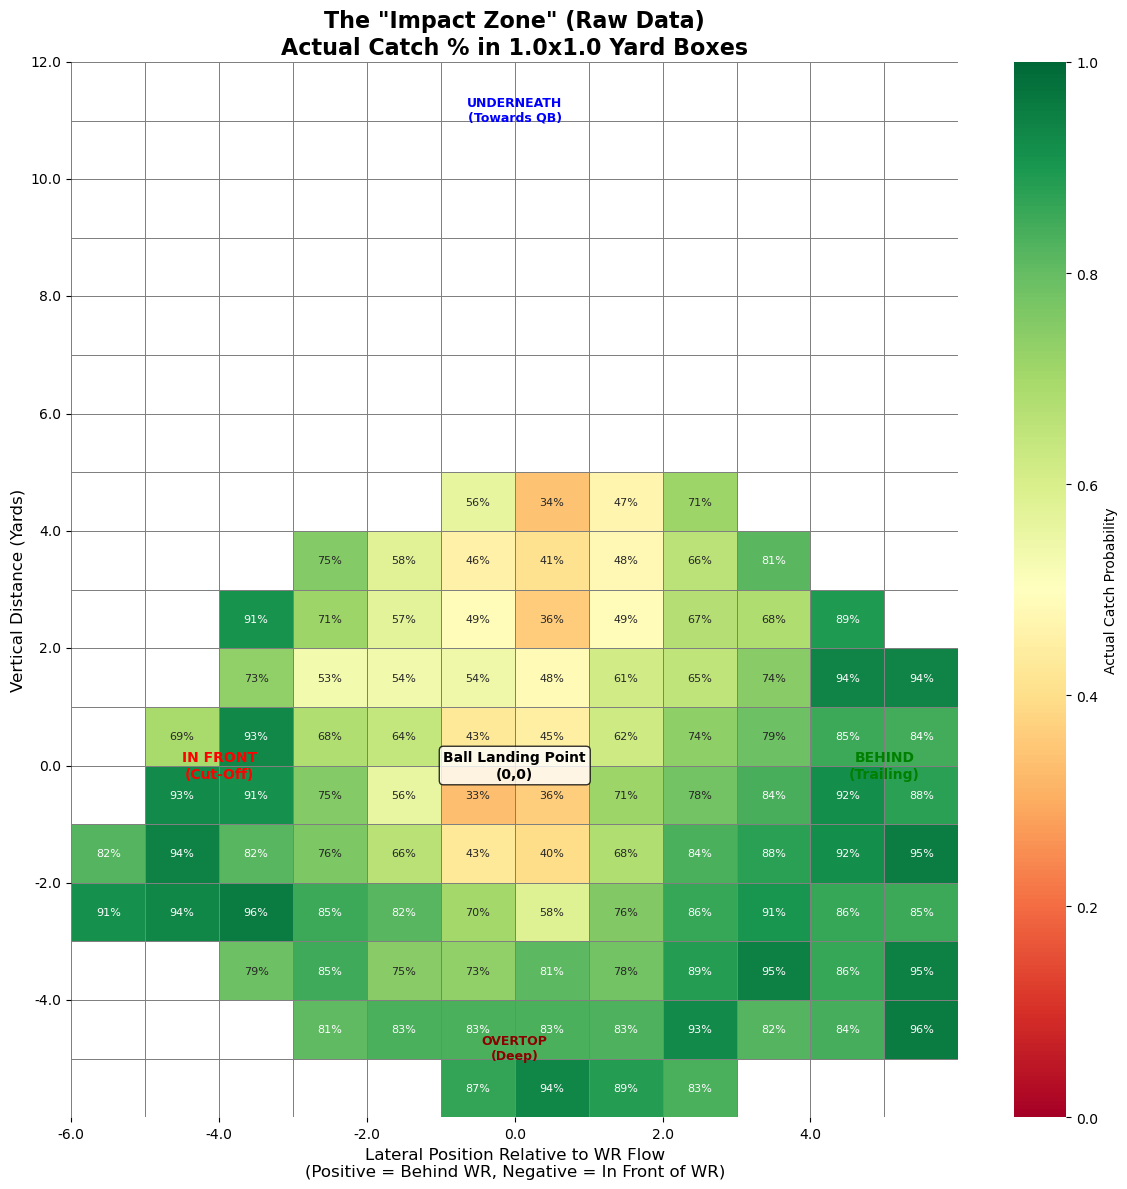

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


# Bin the Data (Create the Boxes)

print("Calculating Bins")

# BIN_SIZE: Size of box in yards.
BIN_SIZE = 1.0
# Minimum plays required to color a box (hides noise)
MIN_PLAYS = 20

# Define the grid edges:
# Lateral: -6 to 6 yards
# Vertical: -6 to 12 yards
x_bins = np.arange(-6, 6 + BIN_SIZE, BIN_SIZE)
y_bins = np.arange(-6, 12 + BIN_SIZE, BIN_SIZE)

# Assign every play to a box
modeling_df['x_bin'] = pd.cut(modeling_df['x_flow'], bins=x_bins)
modeling_df['y_bin'] = pd.cut(modeling_df['y_rotated'], bins=y_bins)

# Calculate Stats per Box
# We group by the boxes and calculate:
# - mean: The Catch Probability (Actual Completion %)
# - count: How many plays happened here (Sample Size)
bin_stats = modeling_df.groupby(['y_bin', 'x_bin'], observed=False)['is_complete'].agg(['mean', 'count'])

# Filter for sample size: If a box has fewer than MIN_PLAYS, we set probability to NaN (make it transparent)
bin_stats.loc[bin_stats['count'] < MIN_PLAYS, 'mean'] = np.nan

# Convert to a Matrix format (Y rows, X columns)
heatmap_matrix = bin_stats['mean'].unstack()

# Sort index descending so "Underneath" (Positive Y) is at the top of the chart
heatmap_matrix = heatmap_matrix.sort_index(ascending=False)

print("Binning complete.")
print(f"Grid Dimensions: {heatmap_matrix.shape}")
print(f"Showing only boxes with >= {MIN_PLAYS} real plays.")


# Visualize the Raw Bins

print("Visualizing Raw Data")

plt.figure(figsize=(12, 12))
plt.title(f'The "Impact Zone" (Raw Data)\nActual Catch % in {BIN_SIZE}x{BIN_SIZE} Yard Boxes', fontsize=16, weight='bold')

# Create Heatmap
sns.heatmap(heatmap_matrix, 
            cmap='RdYlGn', 
            vmin=0, vmax=1, 
            annot=True, fmt=".0%", annot_kws={"size": 8},
            cbar_kws={'label': 'Actual Catch Probability'},
            linewidths=0.5, linecolor='gray')

# Label the Axes
plt.xlabel('Lateral Position Relative to WR Flow\n(Positive = Behind WR, Negative = In Front of WR)', fontsize=12)
plt.ylabel('Vertical Distance (Yards)', fontsize=12)

# Calculate the exact index for (0,0)
zero_x_idx = abs(x_bins[0]) / BIN_SIZE
zero_y_idx = max(y_bins) / BIN_SIZE

print(f"Placing (0,0) label at Grid Indices: X={zero_x_idx}, Y={zero_y_idx}")

# Add the label at the calculated (0,0) point
plt.text(zero_x_idx, zero_y_idx, 'Ball Landing Point\n(0,0)', ha='center', va='center', 
         color='black', weight='bold', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3'))

# Add Context Labels (relative to the zero point)
# Underneath is "Above" the zero point (Lower index)
plt.text(zero_x_idx, 1, 'UNDERNEATH\n(Towards QB)', ha='center', color='blue', fontsize=9, fontweight='bold')
# Overtop is "Below" the zero point (Higher index)
plt.text(zero_x_idx, len(y_bins)-2, 'OVERTOP\n(Deep)', ha='center', color='darkred', fontsize=9, fontweight='bold')

# Behind is to the Right of zero
plt.text(len(x_bins)-2, zero_y_idx, 'BEHIND\n(Trailing)', color='green', fontweight='bold', ha='center', va='center')
# In Front is to the Left of zero
plt.text(2, zero_y_idx, 'IN FRONT\n(Cut-Off)', color='red', fontweight='bold', ha='center', va='center')

# Fix Ticks to show Yards
x_tick_locs = np.arange(0, len(x_bins)-1, 2)
y_tick_locs = np.arange(0, len(y_bins)-1, 2)

x_tick_labels = x_bins[x_tick_locs]
y_tick_labels = y_bins[::-1][y_tick_locs]

plt.xticks(x_tick_locs, np.round(x_tick_labels, 1), rotation=0)
plt.yticks(y_tick_locs, np.round(y_tick_labels, 1), rotation=0)

# Show Plot
plt.tight_layout()
plt.savefig('impact_zone_binned.png', dpi=300)
plt.show()

Creating Manual Impact Zone (Smooth Shape)


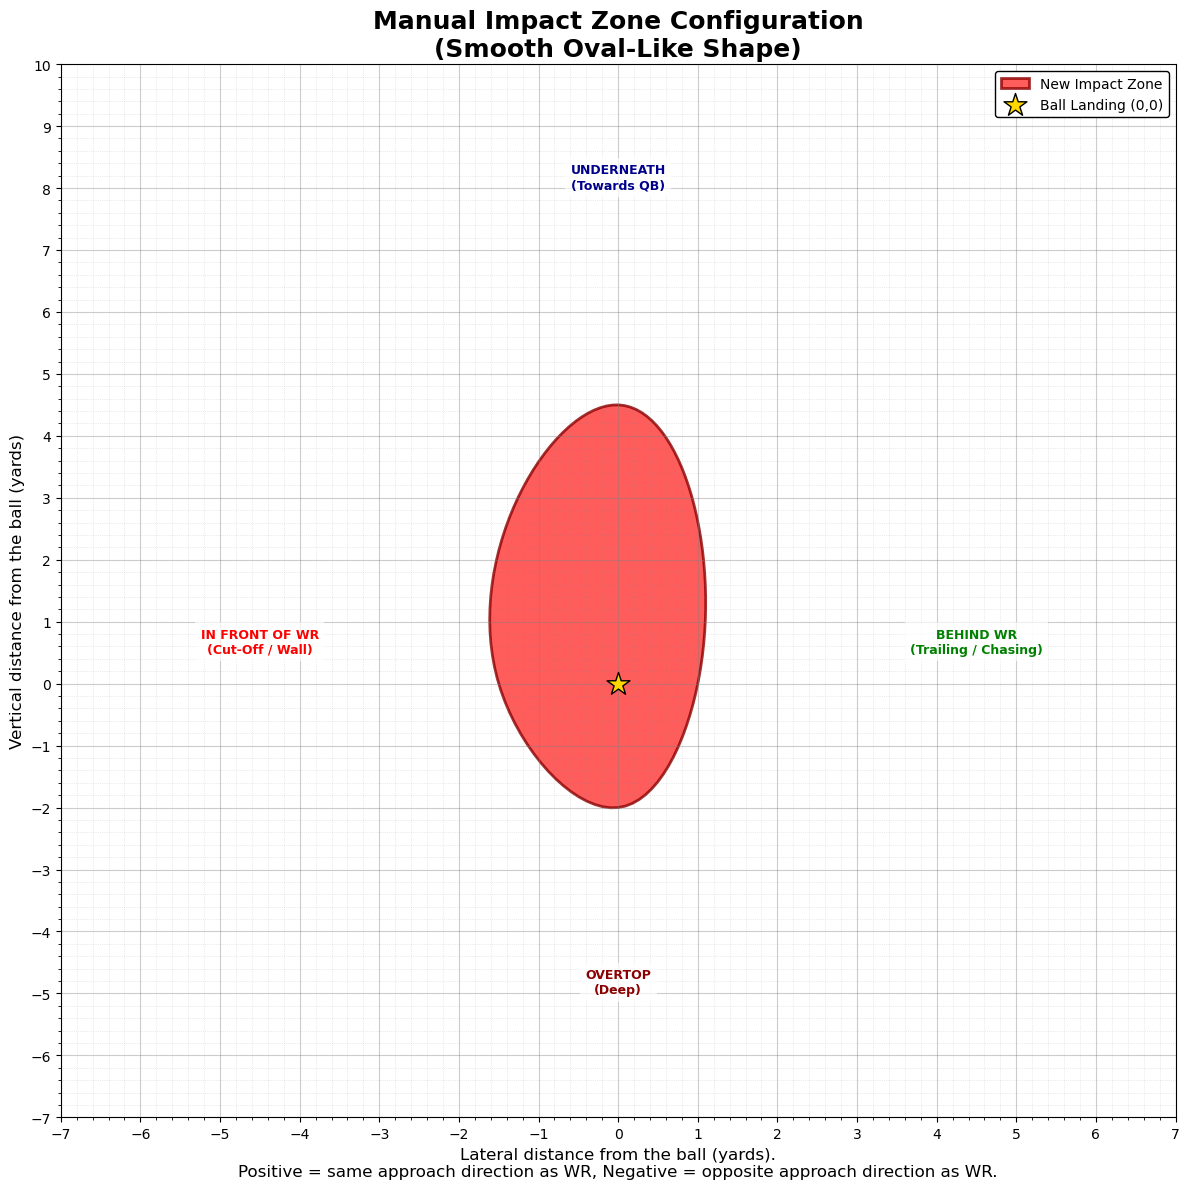

In [11]:
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import splprep, splev


# Manual Zone Creation: Smooth Oval-Like Shape
print("Creating Manual Impact Zone (Smooth Shape)")

# Define the Vertices (The "Anchors" for the curve)
# We add the first point to the end again to help the smoother understand the loop
vertices_anchors = np.array([
    [0, -2],    
    [-1.5, 0],  
    [0, 4.5],  
    [1, 0],  
    [0, -2]    
])

# Generate Smooth Curve 
tck, u = splprep(vertices_anchors.T, u=None, s=0.0, per=1) 

# Create 100 interpolated points to make it look smooth
u_new = np.linspace(u.min(), u.max(), 100)
x_smooth, y_smooth = splev(u_new, tck, der=0)

# Combine into a format for the Polygon function
smooth_vertices = np.column_stack([x_smooth, y_smooth])

# Setup the Plot
plt.figure(figsize=(12, 12))
plt.title("Manual Impact Zone Configuration\n(Smooth Oval-Like Shape)", fontsize=18, weight='bold')

# Create Polygon from smooth vertices
poly_shape = Polygon(smooth_vertices, 
                     closed=True, 
                     facecolor='#FF3333',
                     edgecolor='darkred', 
                     linewidth=2,
                     alpha=0.8,
                     label='New Impact Zone')

# Add patch to the plot
plt.gca().add_patch(poly_shape)

# Add Ball Landing Marker
plt.scatter(0, 0, color='gold', s=300, edgecolors='black', marker='*', zorder=10, label='Ball Landing (0,0)')

# Add Context Labels
plt.text(0, 8, 'UNDERNEATH\n(Towards QB)', ha='center', fontsize=9, fontweight='bold', color='darkblue', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
plt.text(0, -5, 'OVERTOP\n(Deep)', ha='center', fontsize=9, fontweight='bold', color='darkred',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.text(-4.5, 0.5, 'IN FRONT OF WR\n(Cut-Off / Wall)', ha='center', fontsize=9, fontweight='bold', color='red',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
plt.text(4.5, 0.5, 'BEHIND WR\n(Trailing / Chasing)', ha='center', fontsize=9, fontweight='bold', color='green',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Axis Configuration
plt.xlabel('Lateral distance from the ball (yards).\nPositive = same approach direction as WR, Negative = opposite approach direction as WR.', fontsize=12)
plt.ylabel('Vertical distance from the ball (yards)', fontsize=12)

plt.xlim(-7, 7)
plt.ylim(-7, 10)

# Set up the fine grid (Major=1.0, Minor=0.2)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))

plt.grid(True, which='major', color='gray', linestyle='-', linewidth=0.8, alpha=0.4)
plt.grid(True, which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.3)

# Setup Legend
plt.legend(loc='upper right', framealpha=1, edgecolor='black', fontsize=10)

plt.tight_layout()
plt.savefig('manual_zone_smooth_oval.png', dpi=300)
plt.show()

In [12]:
from matplotlib.path import Path

# Analyze Outcomes Inside the Manual Impact Zone
print("Calculating Dispersion Stats Inside the Impact Zone")

# Define the Oval Vertices (Anchors)
vertices_anchors = np.array([
    [0, -2],    
    [-1.5, 0], 
    [0, 3], 
    [1, 0],  
    [0, -2]  
])

# Generate the Smooth Polygon (Exact same logic as the graph)
tck, u = splprep(vertices_anchors.T, u=None, s=0.0, per=1)
u_new = np.linspace(u.min(), u.max(), 100)
x_smooth, y_smooth = splev(u_new, tck, der=0)
smooth_vertices = np.column_stack([x_smooth, y_smooth])

# Identify Plays Inside the Zone
# We create a Path object from the polygon
zone_path = Path(smooth_vertices)

# Get all play coordinates from the dataframe
play_points = modeling_df[['x_flow', 'y_rotated']].values

# Check if each point is inside the polygon
is_inside = zone_path.contains_points(play_points)

# Filter the dataframe
zone_plays = modeling_df[is_inside].copy()

# Calculate Statistics
total_zone_plays = len(zone_plays)

if total_zone_plays > 0:
    # Count outcomes
    outcome_counts = zone_plays['pass_result'].value_counts()
    
    # Extract specific counts
    completions = outcome_counts.get('C', 0)
    incompletions = outcome_counts.get('I', 0)
    interceptions = outcome_counts.get('IN', 0) # Might be 'INT' or 'IN' in your data
    
    # Calculate Percentages
    comp_pct = (completions / total_zone_plays) * 100
    inc_pct = (incompletions / total_zone_plays) * 100
    int_pct = (interceptions / total_zone_plays) * 100
    
    # Print the Report
    print(f"\n===== IMPACT ZONE REPORT =====")
    print(f"Total Plays inside the Zone: {total_zone_plays}")
    print("-" * 30)
    print(f"COMPLETIONS:   {completions}  ({comp_pct:.1f}%)")
    print(f"INCOMPLETIONS: {incompletions}  ({inc_pct:.1f}%)")
    print(f"INTERCEPTIONS: {interceptions}  ({int_pct:.1f}%)")
    print("-" * 30)
    
    # Catch Probability in this zone
    print(f"Raw Catch Probability in Zone: {comp_pct:.1f}%")

else:
    print("No plays found inside this specific zone configuration.")
    

# Analyze Outcomes Outside the Manual Impact Zone
print("Calculating Dispersion Stats Outside the Impact Zone")

# Define the Oval Vertices (Same as before)
vertices_anchors = np.array([
    [0, -2],  
    [-1.5, 0], 
    [0, 4.5],  
    [1, 0], 
    [0, -2]  
])

# Generate the Smooth Polygon
tck, u = splprep(vertices_anchors.T, u=None, s=0.0, per=1)
u_new = np.linspace(u.min(), u.max(), 100)
x_smooth, y_smooth = splev(u_new, tck, der=0)
smooth_vertices = np.column_stack([x_smooth, y_smooth])

# Identify Plays Outside the Zone
zone_path = Path(smooth_vertices)
play_points = modeling_df[['x_flow', 'y_rotated']].values

# Check if points are inside
is_inside = zone_path.contains_points(play_points)

# INVERT the mask to find plays OUTSIDE
# The '~' operator flips True to False and vice versa
outside_plays = modeling_df[~is_inside].copy()

# 4. Calculate Statistics
total_outside = len(outside_plays)

if total_outside > 0:
    outcome_counts = outside_plays['pass_result'].value_counts()
    
    completions = outcome_counts.get('C', 0)
    incompletions = outcome_counts.get('I', 0)
    interceptions = outcome_counts.get('IN', 0)
    
    comp_pct = (completions / total_outside) * 100
    inc_pct = (incompletions / total_outside) * 100
    int_pct = (interceptions / total_outside) * 100
    
    # 5. Print the Report
    print(f"\n===== OUTSIDE ZONE REPORT =====")
    print(f"Total Plays Outside the Zone: {total_outside}")
    print("-" * 30)
    print(f"COMPLETIONS:   {completions}  ({comp_pct:.1f}%)")
    print(f"INCOMPLETIONS: {incompletions}  ({inc_pct:.1f}%)")
    print(f"INTERCEPTIONS: {interceptions}  ({int_pct:.1f}%)")
    print("-" * 30)
    
    print(f"Raw Catch Probability Outside: {comp_pct:.1f}%")

else:
    print("No plays found outside the zone (Check your data or polygon size).")

Calculating Dispersion Stats Inside the Impact Zone

===== IMPACT ZONE REPORT =====
Total Plays inside the Zone: 2224
------------------------------
COMPLETIONS:   919  (41.3%)
INCOMPLETIONS: 1102  (49.6%)
INTERCEPTIONS: 203  (9.1%)
------------------------------
Raw Catch Probability in Zone: 41.3%
Calculating Dispersion Stats Outside the Impact Zone

===== OUTSIDE ZONE REPORT =====
Total Plays Outside the Zone: 9726
------------------------------
COMPLETIONS:   7543  (77.6%)
INCOMPLETIONS: 2112  (21.7%)
INTERCEPTIONS: 71  (0.7%)
------------------------------
Raw Catch Probability Outside: 77.6%


In [13]:
# Generate and Save the Smooth Impact Zone
print("Generating and Saving Impact Zone Object")

# Define the Anchors (Vertices)
vertices_anchors = np.array([
    [0, -2],   
    [-1.5, 0],
    [0, 4.5],    
    [1, 0],     
    [0, -2]     
])

# Generate the Smooth Curve
tck, u = splprep(vertices_anchors.T, u=None, s=0.0, per=1)
u_new = np.linspace(u.min(), u.max(), 100)
x_smooth, y_smooth = splev(u_new, tck, der=0)

# Create a DataFrame of the Exact Shape
shape_df = pd.DataFrame({
    'rel_x': x_smooth,
    'rel_y': y_smooth
})

# Save to CSV
filename = 'impact_zone_shape_v1.csv'
shape_df.to_csv(filename, index=False)

print(f"Shape saved to '{filename}'")
print(f"   - Contains {len(shape_df)} smoothed vertices.")
print(f"   - You can now load this file in any other notebook.")

Generating and Saving Impact Zone Object
Shape saved to 'impact_zone_shape_v1.csv'
   - Contains 100 smoothed vertices.
   - You can now load this file in any other notebook.
